In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [36]:
def get_gs(df, tm = 'Tliq', jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df[tm] # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df[tm]
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tliq)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df[tm] - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df[tm] - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tliq - df.Tg)
    df['K_cr'] = (df.Tliq - df.Tx) / (df.Tliq - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tl)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tl)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tl - 1))
    
def get_gfa(df, logXs = -2, logNs = 3, g=pi, **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df.Tl - df.T_Umax) / tn)
    return df

In [3]:
os.getcwd()

'/Users/sarahisabelallec/Library/CloudStorage/Box-Box/Sarah_Personal/ZOSMA/GFA_PAPER/FINAL_FIGURES'

# Load models and data

In [4]:
glassnet_no_stnn = GlassNet(st_models=[])
glassnet_stnn = GlassNet()

In [5]:
glassnet_test_df = pd.read_csv('glassnet_test_df.csv', index_col=0, header=[0, 1])
glassnet_train_df = pd.read_csv('glassnet_train_df.csv', index_col=0, header=[0, 1])

In [6]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [7]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)
X_glassnet_feats_total, feats = glassnet_stnn.featurizer(X_glassnet_total, return_cols = True)

In [8]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)
X_glassnet_feats_total = pd.DataFrame(X_glassnet_feats_total, columns = feats)

In [9]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index
X_glassnet_feats_total.index = X_glassnet_total.index

In [26]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

# Compute true GS parameters

In [11]:
gs_glassnet_train = get_gs(y_glassnet_train )
gs_glassnet_test = get_gs( y_glassnet_test )
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test) )

In [12]:
gfa_glassnet_train = get_gfa(y_glassnet_train)
gfa_glassnet_test = get_gfa(y_glassnet_test)
gfa_glassnet_total = pd.concat( (gfa_glassnet_train, gfa_glassnet_test) )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Evaluate RF accuracy for GS prediction for different glass families

In [13]:
formers = ['Si', 'P', 'B', 'Al']
modifiers = ['Na', 'Li', 'K', 'Cs', 'Ca', 'Mg'] # have not used yet

In [14]:
X_by_former = []
for former in formers:
    X_by_former.append( X_glassnet_total[ X_glassnet_total[former] >  X_glassnet_total[ [f for f in formers if f != former] ].sum(axis=1) ] )   

In [15]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

## Characteristic temperatures

In [22]:
temp_cols = ['Tg', 'Tc', 'Tx', 'Tliq']
temp_titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$']
colors = ['coral', 'dodgerblue', 'mediumaquamarine', 'orchid']
ecolors = ['darkred', 'navy', 'teal', 'darkmagenta']
alphas = [0.8, 0.7, 0.6, 0.6]

In [29]:
source = SciGlass()
df = source.data
source.remove_duplicate_composition(aggregator='std')
df_std = source.data.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tliq'})
quantiles = df_std.property[temp_cols].quantile(q=0.75)

Tg Si 2152 0.9464049278823842 19.41487267682109 10.292590959029836
Tg P 1324 0.9172655341411932 22.493999999066563 10.292590959029836
Tg B 1618 0.9348769276289125 17.069516069579706 10.292590959029836
Tg Al 333 0.9794213276187373 15.265195195195291 10.292590959029836
Tc Si 473 0.8823451299853841 46.36510561017609 33.23401871576773
Tc P 265 0.9231468438253857 32.763773584905735 33.23401871576773
Tc B 225 0.8991907375739929 33.67964888780386 33.23401871576773
Tc Al 137 0.9671325897190943 23.86497081895823 33.23401871576773
Tx Si 128 0.9135167423820214 39.489242186546335 20.506096654409877
Tx P 162 0.9268303270376603 27.100679012345765 20.506096654409877
Tx B 101 0.9433816815808642 26.236445542137453 20.506096654409877
Tx Al 147 0.9516527002530895 22.913183676791018 20.506096654409877
Tliq Si 2160 0.9326719984618368 33.131818794957034 7.723145199062156
Tliq P 331 0.9455631546740172 38.301362540715104 7.723145199062156
Tliq B 477 0.9551794159869965 24.68743606023591 7.723145199062156
Tliq 

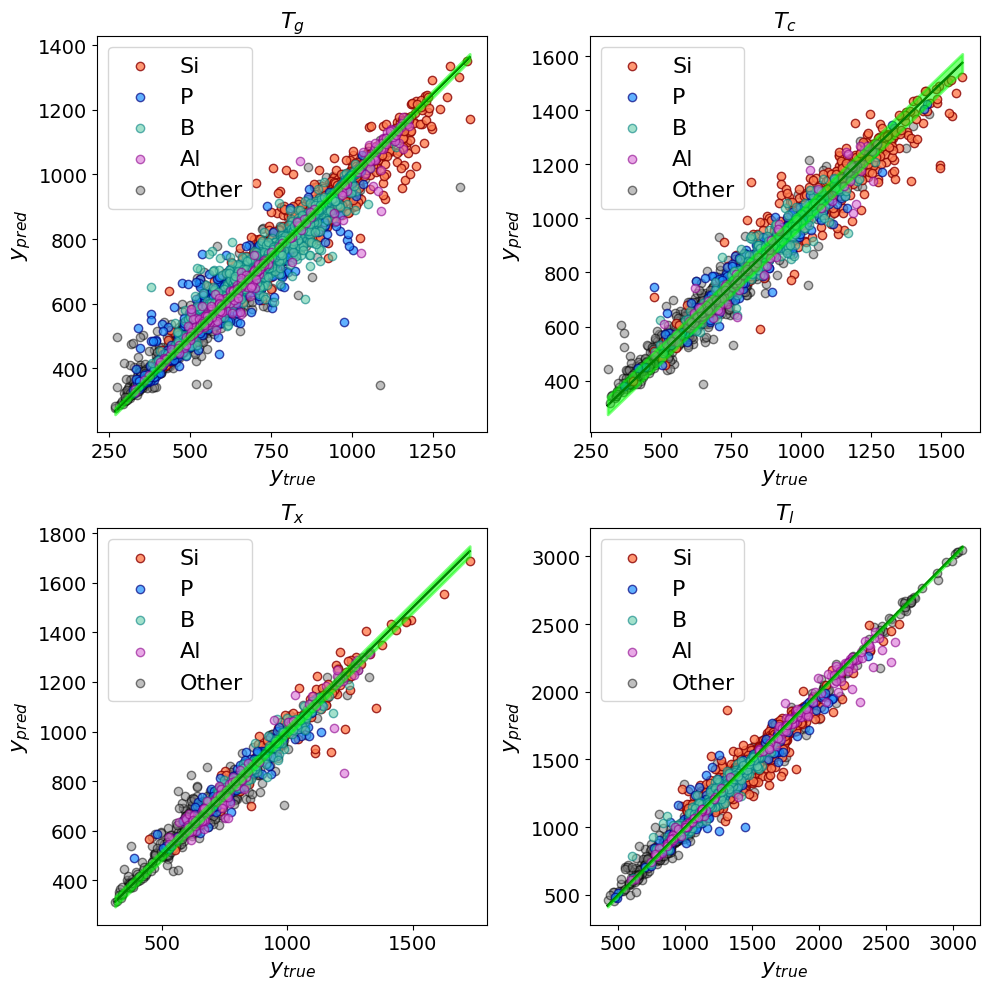

In [30]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
r2_arr = np.zeros( ( len(formers) + 1, len(temp_cols) ) )
resids_t = {col:[] for col in temp_cols}

y_pred_rf = pd.read_csv(f'rf_preds_iteration0.csv', index_col=0)
for i, col in enumerate(temp_cols[:4]):
    
    if i < 2:
        ax = axes[0,i]
    else:
        ax = axes[1,i-2]
    y_true_all = []
    former_inds = []
    for j,former in enumerate( formers ):
        X = X_by_former[j]
        inds_test = y_glassnet_test[col].dropna().index.intersection( X.index )
        y_test = y_glassnet_test.loc[inds_test, col]
        y_rf_pred = y_pred_rf.loc[inds_test, col]
        y_rf_pred.index = inds_test
        
        ax.scatter(y_test, y_rf_pred, color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former, zorder=2)
        print( col, former, len(inds_test), r2_score( y_test, y_rf_pred ), mean_absolute_error( y_test, y_rf_pred ), quantiles[col] )
        r2_arr[j,i] = r2_score( y_test, y_rf_pred )
        resids_t[col].append( y_rf_pred - y_test )
        for y in y_test:
            if y not in y_true_all:
                y_true_all.append(y)
        for ind in list( inds_test ):
            former_inds.append(ind)
    y_true_line = np.linspace(min(y_glassnet_test[col].dropna()), max(y_glassnet_test[col].dropna()), 100)
    ax.plot(y_true_line, y_true_line, color='k')
    ax.plot(y_true_line, y_true_line, color='k')
    ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='lime', alpha=.5, linewidth=2.0, zorder=3 )
    
    other_inds = [ i for i in list(y_glassnet_test[col].dropna().index) if i not in former_inds ]
    others_y_pred = y_pred_rf.loc[ other_inds, col ]
    others_y_pred.index = other_inds
    ax.scatter(y_glassnet_test.loc[other_inds, col].dropna(),  others_y_pred, color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
    r2_arr[-1,i] = r2_score( y_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    
    resids_t[col].append( others_y_pred - y_glassnet_test.loc[other_inds, col] )
    #ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='yellow', alpha=.5)
    
    ax.legend()
    ax.set_title(temp_titles[i])
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
fig.savefig('figures3.png', dpi=600)

In [31]:
r2_df = pd.DataFrame( r2_arr, columns = temp_cols )
r2_df.index = formers + ['other']

In [32]:
r2_df

,Tg,Tc,Tx,Tliq
Si,0.946405,0.882345,0.913517,0.932672
P,0.917266,0.923147,0.926830,0.945563
B,0.934877,0.899191,0.943382,0.955179
Al,0.979421,0.967133,0.951653,0.985249
other,0.954603,0.950446,0.949936,0.988752


In [37]:
gs_rf_pred = get_gs( y_pred_rf )

In [38]:
gs_rf_pred.index = X_glassnet_test.index

In [39]:
gs_cols = ['K_W_Tc', 'gamma_Tc', 'H_prime_Tc']
gs_titles = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', 
          r'$H^{\prime}(T_{c})$']

In [40]:
myrcparams = {
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

K_W_Tc Si 19 0.6760007874808571 0.026345105718722325
K_W_Tc P 9 0.23668083749866753 0.030556541591890887
K_W_Tc B 31 0.2025792739517983 0.03319572814814018
K_W_Tc Al 7 0.7764819485026826 0.012350377471227346
57
gamma_Tc Si 19 0.68675725020712 0.016738579556854462
gamma_Tc P 9 0.4975558781347793 0.01697652831325828
gamma_Tc B 31 0.2599091805356507 0.02488931561094379
gamma_Tc Al 7 0.8390395459487855 0.009108745054500418
57
H_prime_Tc Si 331 0.5306400395624112 0.058187296104145414
H_prime_Tc P 252 0.6028475929972019 0.049719794052740234
H_prime_Tc B 200 0.6059649419806443 0.05301971028115627
H_prime_Tc Al 120 0.3955634433433992 0.035465913754141896
801


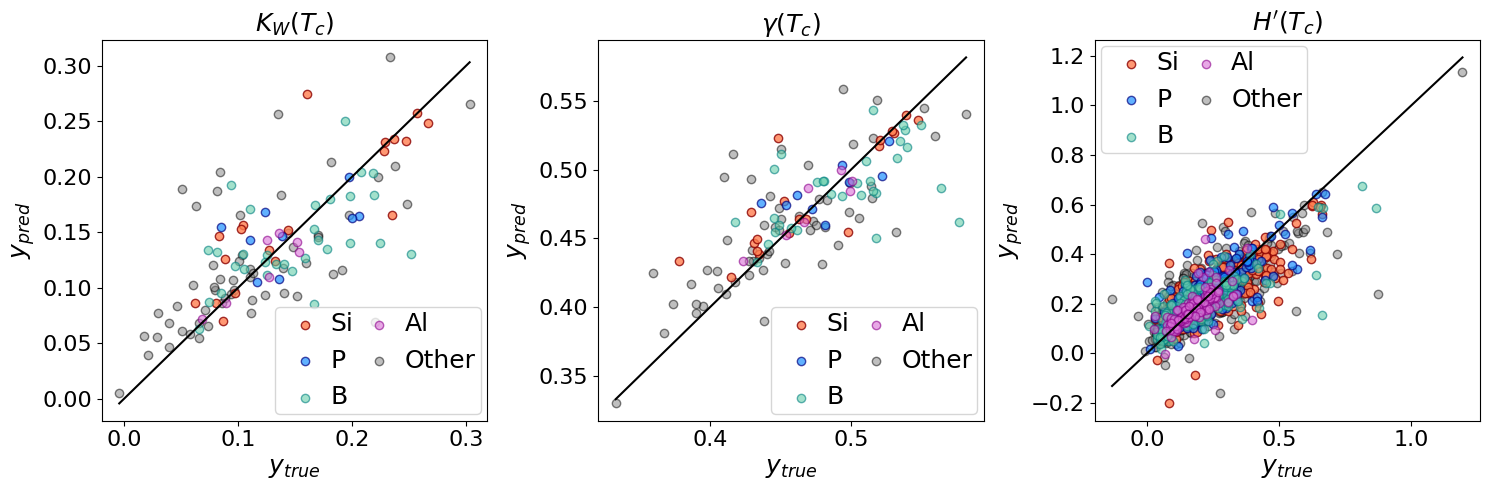

In [42]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
r2_arr = np.zeros( ( len(formers) + 1, len(gs_cols) ) )
mae_arr = np.zeros( ( len(formers) + 1, len(gs_cols) ) )
resids_gs = {col:[] for col in gs_cols}
for i, col in enumerate(gs_cols):
    
    ax = axes[i]
    y_true_all = []
    former_inds = []
    for j,former in enumerate( formers ):
        X = X_by_former[j]
        inds_test = gs_glassnet_test[col].dropna().index.intersection( X.index )
        y_test = gs_glassnet_test.loc[inds_test, col]
        y_rf_pred = gs_rf_pred.loc[inds_test, col]
        
        ax.scatter(y_test, y_rf_pred, color = colors[j], alpha = alphas[j], edgecolor = ecolors[j], label = former, zorder=2)
        print( col, former, len(inds_test), r2_score( y_test, y_rf_pred ), mean_absolute_error( y_test, y_rf_pred ) )
        r2_arr[j,i] = r2_score( y_test, y_rf_pred )
        mae_arr[j,i] = mean_absolute_error( y_test, y_rf_pred )
        resids_gs[col].append( y_rf_pred - y_test )
        for y in y_test:
            if y not in y_true_all:
                y_true_all.append(y)
        for ind in list( inds_test ):
            former_inds.append(ind)
    y_true_line = np.linspace(min(gs_glassnet_test[col].dropna()), max(gs_glassnet_test[col].dropna()), 100)
    ax.plot(y_true_line, y_true_line, color='k')

    
    other_inds = [ i for i in list(gs_glassnet_test[col].dropna().index) if i not in former_inds ]
    print(len(other_inds))
    others_y_pred = gs_rf_pred.loc[ other_inds, col ]
    ax.scatter(gs_glassnet_test.loc[other_inds, col].dropna(),  others_y_pred, color = 'gray', edgecolor='black', alpha = 0.5, zorder=1, label='Other')
    resids_gs[col].append( others_y_pred - gs_glassnet_test.loc[other_inds, col] )
    
    r2_arr[-1,i] = r2_score( gs_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    mae_arr[-1,i] = mean_absolute_error( gs_glassnet_test.loc[other_inds, col].dropna(), others_y_pred )
    #ax.fill_between(y_true_line, (y_true_line-quantiles[col]), (y_true_line+quantiles[col]), color='yellow', alpha=.5)
    
    ax.legend(ncol=2, columnspacing=0.05, handletextpad = 0.025, borderpad = 0.2, borderaxespad = 0.25)
    ax.set_title(gs_titles[i])
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
fig.savefig('figures4_1.png', dpi=600)

In [43]:
r2_df = pd.DataFrame( r2_arr, columns = gs_cols )
r2_df.index = formers + ['other']

In [44]:
r2_df

,K_W_Tc,gamma_Tc,H_prime_Tc
Si,0.676001,0.686757,0.530640
P,0.236681,0.497556,0.602848
B,0.202579,0.259909,0.605965
Al,0.776482,0.839040,0.395563
other,0.363140,0.561574,0.591284


In [45]:
mae_df = pd.DataFrame( mae_arr, columns = gs_cols )
mae_df.index = formers + ['other']

In [46]:
mae_df

,K_W_Tc,gamma_Tc,H_prime_Tc
Si,0.026345,0.016739,0.058187
P,0.030557,0.016977,0.049720
B,0.033196,0.024889,0.053020
Al,0.012350,0.009109,0.035466
other,0.036699,0.024880,0.051049


In [47]:
from scipy.stats import kendalltau

Si Tc K_W_Tc 19 0.543859649122807
Si Tc gamma_Tc 19 0.7192982456140351
Si Tc H_prime_Tc 331 0.6072873752632061
B Tc K_W_Tc 31 0.6258064516129033
B Tc gamma_Tc 31 0.6172043010752688
B Tc H_prime_Tc 200 0.6057286432160803
Al Tc H_prime_Tc 120 0.5980392156862745
other Tc K_W_Tc 57 0.5789473684210528
other Tc H_prime_Tc 801 0.5240965171577249


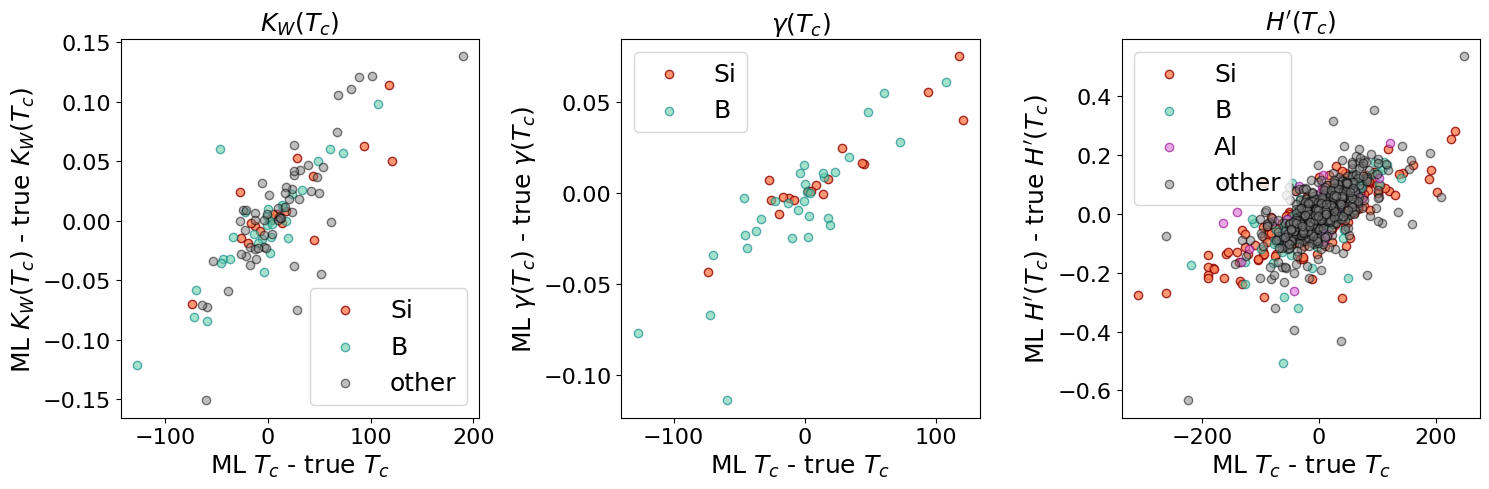

In [48]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
colors = colors + ['gray']
ecolors = ecolors + ['black']
alphas = alphas + [0.5]
for i,col in enumerate(temp_cols[:4]):

    for j,former in enumerate(formers+["other"]):
        this_resids_t = resids_t[col][j]
        
        for k, gs_col in enumerate(gs_cols):
            ax = axes[k]
            this_resids_gs = resids_gs[gs_col][j]
            inds = this_resids_t.index.intersection( this_resids_gs.index )
            tau_gs = kendalltau( this_resids_t.loc[inds], this_resids_gs.loc[inds] )

            if len(inds) > 10:
                if tau_gs[0] > 0.5 and tau_gs[1] < 0.05:
                    print(former, col, gs_col, len(inds), tau_gs[0])
                    
                    ax.scatter(this_resids_t.loc[inds], this_resids_gs.loc[inds], color = colors[j], alpha = alphas[j], 
                       edgecolor = ecolors[j], label = former)
                    #ax.legend(ncol=2, columnspacing=0.05, handletextpad = 0.025, borderpad = 0.2, borderaxespad = 0.25)
                    ax.legend()
                    ax.set_title(gs_titles[k])
                    ax.set_xlabel(f'ML {temp_titles[i]} - true {temp_titles[i]}')
                    ax.set_ylabel(f'ML {gs_titles[k]} - true {gs_titles[k]}' )
        fig.savefig('figures4_2.png')

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
for i,col in enumerate(temp_cols[:4]):
    y_true = y_glassnet_test[col].dropna()
    y_pred = y_pred_rf.loc[ y_true.index, col ]

    print(col, mean_absolute_error( y_true, y_pred ), np.sqrt( mean_squared_error( y_true, y_pred ) ), quantiles[col] )

Tg 18.94033758445508 34.19378033467758 10.292590959029836
Tc 34.20369927053355 51.566350597459746 33.23401871576773
Tx 28.85993168115011 44.29748120970581 20.506096654409877
Tliq 32.290507059889116 53.41721075765627 7.723145199062156
